# Media Monitor Analysis

Part of a joint research project between the [School of Computer Science](https://www.cs.cf.ac.uk/) and the [School of Journalism](http://www.cardiff.ac.uk/journalism-media-cultural-studies) at Cardiff University. 

---

*This notebook requires a mongoDB database called **`media-monitor`** with a **`tweets`** collection containing [Tweet objects](https://dev.twitter.com/overview/api/tweets). It aims to analyse the data collected by the [media-monitor](https://github.com/taylorrees/media-monitor) tool.*

## Table of Contents

- [Key Terms](#Key-Terms)
- [Getting Started](#Getting-Started)
- [Original Tweet Analysis](#Original-Tweet-Analysis)
- [Retweet Analysis](#Retweet-Analysis)
- [Reply Analysis](#Reply-Analysis)
- [Link Analysis](#Link-Analysis)
- [Hashtag Analysis](#Hashtag-Analysis)

---

## Key Terms

**`JOI`** Journalists of interest

**`OOI`** Organisations of interest

**`EXT`** Accounts not followed by streaming api

## Getting Started

To get started import the dependencies. 

*We also need to extend the `Collect` class to cater to our needs as we want the store method to clear a specified collection everytime it is called.*

In [74]:
from db import DB
from json import load
from collect import Collect
from collections import Counter
from IPython.display import display
from IPython.display import Markdown

# allow inline plotting
%matplotlib inline
import matplotlib.pyplot as plt

class Collect(Collect):
    def store(self, collection):
        # extend and alter store
        DB[collection].delete_many({})
        DB[collection].insert_many(self.members)

Next, setup new collections in the database.

_**Note**_

Only call if the journalists and organisations collections are not already setup in the database. This will read the JSON files containing journalist and organisation twitter lists and store them in the appropriate database.

In [ ]:
# get & store journalists from twitter lists
j = load(open("journalists.json"))
collect = Collect(lists=j)
collect.store("journalists")

# get & store news organisations from twitter lists
o = load(open("organisations.json"))
collect = Collect(lists=o, refine=False, append=True)
collect.store("organisations")

### Original Tweet Analysis

This section of the analysis aims to look at the number of original tweets authored throughout the data collection period. An original tweet is one that has been published by a user that is not a reply nor a retweet. We will look for tweets authored by the `JOI`, `OOI` and `EXT` accounts. 

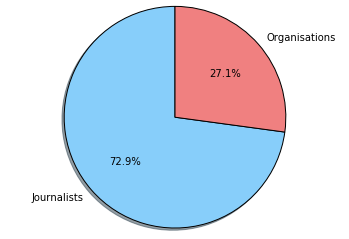

In [65]:
# get sets of id_str's
journalists = DB.journalists.distinct("id_str")
organisations = DB.organisations.distinct("id_str")

joi = DB.tweets.find({
    "user.id_str": {"$in": journalists},
    "in_reply_to_status_id_str": {"$eq": None},
    "retweeted_status": {"$exists": False}
}).count()

ooi = DB.tweets.find({
    "user.id_str": {"$in": organisations},
    "in_reply_to_status_id_str": {"$eq": None},
    "retweeted_status": {"$exists": False}
}).count()

# calculate mean percentage
total = joi + ooi
joi = (joi / total) * 100
ooi = (ooi / total) * 100

# data to plot
sizes = [joi, ooi]
labels = "Journalists", "Organisations"
colors = ['lightskyblue', 'lightcoral']

# plot
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', 
        shadow=True, startangle=90)

plt.axis('equal')
plt.show()


### Retweet Analysis

This section of the analysis aims to look at the number of retweets created throughout the data collection period. 

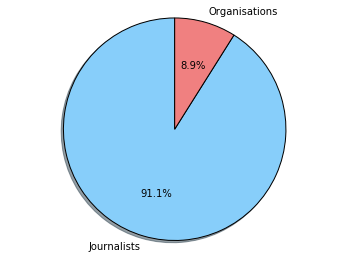

In [66]:
# get sets of id_str's
journalists = DB.journalists.distinct("id_str")
organisations = DB.organisations.distinct("id_str")

joi = DB.tweets.find({
    "user.id_str": {"$in": journalists},
    "retweeted_status": {"$exists": True}
}).count()

ooi = DB.tweets.find({
    "user.id_str": {"$in": organisations},
    "retweeted_status": {"$exists": True}
}).count()

# calculate mean percentage
total = joi + ooi
joi = (joi / total) * 100
ooi = (ooi / total) * 100

# data to plot
sizes = [joi, ooi]
labels = "Journalists", "Organisations"
colors = ['lightskyblue', 'lightcoral']

# plot
plt.pie(sizes, labels=labels, colors=colors, 
        autopct='%1.1f%%', shadow=True, startangle=90)

plt.axis('equal')
plt.show()

### Reply Analysis

This section of the analysis aims to look at the number of replies authored throughout the data collection period. 

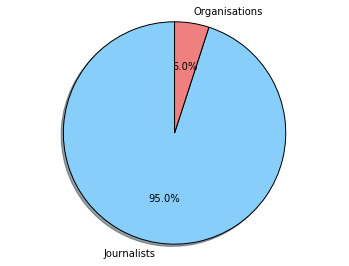

In [67]:
# get sets of id_str's
journalists = DB.journalists.distinct("id_str")
organisations = DB.organisations.distinct("id_str")

joi = DB.tweets.find({
    "user.id_str": {"$in": journalists},
    "in_reply_to_status_id_str": {"$ne": None}
}).count()

ooi = DB.tweets.find({
    "user.id_str": {"$in": organisations},
    "in_reply_to_status_id_str": {"$ne": None}
}).count()

# calculate mean percentage
total = joi + ooi
joi = (joi / total) * 100
ooi = (ooi / total) * 100

# data to plot
sizes = [joi, ooi]
labels = "Journalists", "Organisations"
colors = ['lightskyblue', 'lightcoral']

# plot
plt.pie(sizes, labels=labels, colors=colors, 
        autopct='%1.1f%%', shadow=True, startangle=90)

plt.axis('equal')
plt.show()

### Link Analysis

This section of the analysis aims to look at the number of links included in the body of the tweets collected throughout the data collection period. 

In [103]:
"""Count the number of tweets containing links and
the number of unique links. Get the urls and determine
the 10 most common urls."""

tweets = [t for t in DB.tweets.find()]
urls = [h["expanded_url"] for t in tweets for h in t["entities"]["urls"]]
most_common = Counter(urls).most_common(10)
most_common = [(key, value) for (key, value) in most_common]

# data to output
table1 = " | Links | Unique | \n"
table1 += "| ----- | ------ | \n"
table1 += "| %s | %s | \n" % (len(urls), len(set(urls)))

table2 = " | URL | Occurances | \n"
table2 += "| --- | ---------- | \n"

for url, occ in most_common:
    table2 += "| %s | %s | \n" % (url, occ)

# output
display(Markdown("**Overall**"))
display(Markdown(table1))
display(Markdown("**Top 10**"))
display(Markdown(table2))

**Overall**

 | Links | Unique | 
| ---- | ---- | 
| 3195 | 657 | 


**Top 10**

 | URL | Occurances | 
| ---- | ---- | 
| http://bbc.co.uk/chilcot | 586 | 
| http://snpy.tv/29w8hdD | 173 | 
| http://bbc.in/29lj1LX | 146 | 
| http://cnn.it/29gUodd | 70 | 
| http://reut.rs/29lj4HT | 60 | 
| http://www.telegraph.co.uk/news/2016/07/06/chilcot-inquiry-judgement-day-for-tony-blair-as-iraq-war-report/ | 58 | 
| http://bbc.in/29l5lRm | 45 | 
| http://snpy.tv/29hfPeJ | 44 | 
| http://ind.pn/29nxzqs | 42 | 
| http://nyti.ms/29w2dli | 40 | 


### Hashtag Analysis

This section of the analysis aims to look at the number of hashtags included in the body of the tweets collected throughout the data collection period. 

In [106]:
"""Count the number of tweets containing hashtags and
the number of unique hashtags. Get the hashtags and
determine the 10 most common hashtags."""

tweets = [t for t in DB.tweets.find()]
hashtags = [h["text"] for t in tweets for h in t["entities"]["hashtags"]]
most_common = Counter(hashtags).most_common(20)
most_common = [(key, value) for (key, value) in most_common]

# data to output
table1 = " | Hashtags | Unique | \n"
table1 += "| -------- | ------ | \n"
table1 += "| %s | %s | \n" % (len(hashtags), len(set(hashtags)))

table2 = " | Hashtag | Occurances | \n"
table2 += "| ------- | ---------- | \n"

for hashtag, occ in most_common:
    table2 += "| %s | %s | \n" % (hashtag, occ)

# output
display(Markdown("**Overall**"))
display(Markdown(table1))
display(Markdown("**Top 10**"))
display(Markdown(table2))


**Overall**

 | Hashtags | Unique | 
| -------- | ------ | 
| 1735 | 167 | 


**Top 10**

 | Hashtag | Occurances | 
| ------- | ---------- | 
| Chilcot | 1168 | 
| OscarPistorius | 90 | 
| AltonSterling | 47 | 
| ChilcotReport | 47 | 
| PMQs | 28 | 
| Brexit | 25 | 
| NewsOneNow | 21 | 
| IraqWar | 17 | 
| KellyFile | 12 | 
| Hannity | 10 | 
| LionelMessi | 10 | 
| blair | 9 | 
| Iraq | 9 | 
| devastating | 8 | 
| IraqInquiry | 8 | 
| BaghdadAttack | 8 | 
| Messi | 8 | 
| EUreferendum | 6 | 
| PokemonGO | 6 | 
| MUFC | 5 | 
